In [67]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hdbscan import HDBSCAN
from sklearn.decomposition import SparsePCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, robust_scale
from umap import UMAP

sns.set_theme(context="notebook", style="darkgrid")
random_state = 42

## Task

Target: Need to perform clustering to summarize customer segments.  
Data source and description: https://www.kaggle.com/imakash3011/customer-personality-analysis


Load data


In [68]:
data = pd.read_csv(
    filepath_or_buffer="data\\marketing_campaign.csv",
    sep="\t",
    parse_dates=["Dt_Customer", "Year_Birth"],
)

data = data.fillna(0)

### Extract Features

- Convert maritial status to four categories
- Combine "kids" and "teens" columns
- Convert Costumer age to integer
- Clip unrealistic values for year born and income


In [69]:
data.set_index("ID", inplace=True)
data.replace(
    to_replace={
        "YOLO": "Single",
        "Absurd": "Single",
        "Alone": "Single",
        "Together": "Married",
    },
    inplace=True,
)

data_original = data.copy()
data.Year_Birth = np.clip(data.Year_Birth, "1940", "2020")
data["Year_Birth_int"] = data.Year_Birth.view("int64")
data["Dt_Customer_int"] = data["Dt_Customer"].view("int64")

data["NumAcceptedTotal"] = data.loc[:, "AcceptedCmp3":"AcceptedCmp2"].sum(axis=1)
data.Kidhome += data["Teenhome"]
data.drop(
    [
        "Teenhome",
        "Z_CostContact",
        "Z_Revenue",
        "Year_Birth",
        "Dt_Customer",
        "AcceptedCmp1",
        "AcceptedCmp2",
        "AcceptedCmp3",
        "AcceptedCmp4",
        "AcceptedCmp5",
    ],
    axis=1,
    inplace=True,
)
data.Income = np.clip(data.Income, 10_000, 150_000)

Calculate total amount of money spent


In [70]:
money_spent_total = (
    data["MntWines"]
    + data["MntFruits"]
    + data["MntMeatProducts"]
    + data["MntFishProducts"]
    + data["MntSweetProducts"]
    + data["MntGoldProds"]
).rename("Money spent total")

Encode categorical features


In [71]:
Education_categories = ["Basic", "Graduation", "2n Cycle", "Master", "PhD"]

ordinal_enc = OrdinalEncoder(categories=[Education_categories], dtype="int")

oh_enc = OneHotEncoder(sparse=False, dtype="int")

education_ordinal = pd.DataFrame(
    ordinal_enc.fit_transform(X=np.array(data.Education).reshape(-1, 1))
).set_index(data.index)

Marital_Status_binary = pd.DataFrame(
    oh_enc.fit_transform(X=np.array(data["Marital_Status"]).reshape(-1, 1)),
    columns=data.Marital_Status.unique(),
).set_index(data.index)

data = pd.concat([data, education_ordinal, Marital_Status_binary], axis=1)
data = data.drop(labels=["Education", "Marital_Status"], axis=1)
data_columns = data.columns

### Select useful features


In [72]:
model = VarianceThreshold(0.2)
data = robust_scale(X=data, with_centering=True)
data = model.fit_transform(data)
data_columns = model.get_feature_names_out(data_columns)

EDA


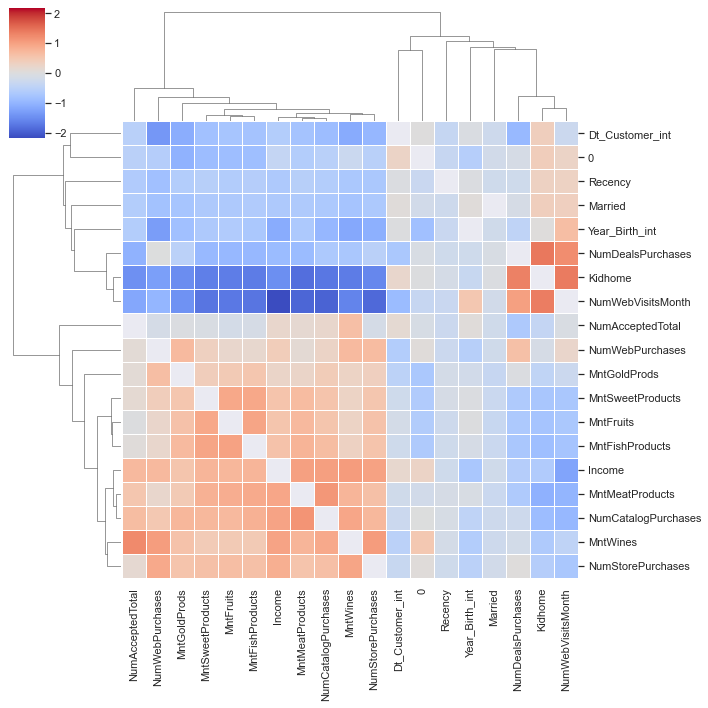

In [73]:
mask = np.identity(len(data_columns))
sns.clustermap(
    pd.DataFrame(data, columns=data_columns).corr(method="pearson"),
    metric="correlation",
    mask=mask,
    cmap="coolwarm",
    z_score=1,
    norm=colors.CenteredNorm(),
    linewidths=0.5,
)

### Hypothesis

- Number of Kids and number of Web Visits correlate negative with income and money spend
- Income correlates very strongly positive with number of purchases and money spent on products (all categories)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'Income'),
  Text(1.5, 0, 'Kidhome'),
  Text(2.5, 0, 'Recency'),
  Text(3.5, 0, 'MntWines'),
  Text(4.5, 0, 'MntFruits'),
  Text(5.5, 0, 'MntMeatProducts'),
  Text(6.5, 0, 'MntFishProducts'),
  Text(7.5, 0, 'MntSweetProducts'),
  Text(8.5, 0, 'MntGoldProds'),
  Text(9.5, 0, 'NumDealsPurchases'),
  Text(10.5, 0, 'NumWebPurchases'),
  Text(11.5, 0, 'NumCatalogPurchases'),
  Text(12.5, 0, 'NumStorePurchases'),
  Text(13.5, 0, 'NumWebVisitsMonth'),
  Text(14.5, 0, 'Year_Birth_int'),
  Text(15.5, 0, 'Dt_Customer_int'),
  Text(16.5, 0, 'NumAcceptedTotal'),
  Text(17.5, 0, '0'),
  Text(18.5, 0, 'Married')])

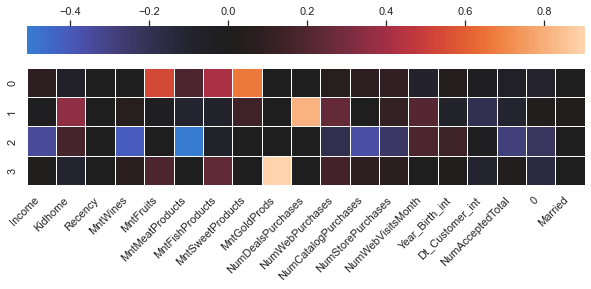

In [74]:
fa = SparsePCA(
    n_components=4,
    alpha=0.1,
    # n_jobs=-1
    # rotation="varimax"
)
fa.fit(data)

plt.figure(figsize=(10, 5))
sns.heatmap(
    pd.DataFrame(fa.components_, columns=data_columns),
    square=True,
    cbar_kws={"orientation": "horizontal", "location": "top"},
    linewidths=1,
    center=0,
)

plt.xticks(rotation=45, horizontalalignment="right")

### Hyptothesis:

We have

- one group that buys Fruits, Fish and sweets
- one group that has kids and uses deals
- one group that has high income and buys wines and meat from the catalogue
- one group that buys gold
- or some kombination of the above


## Clustering

We use UMAP to embed the datapoints into three dimensions. We then use HDBSCAN to discover clusters of high density and outliers. The parameters were chosen such that we get ~3 to 5 clusters total with few outliers.


In [75]:
reducer = UMAP(
    n_components=3,
    local_connectivity=2,
    min_dist=0,
    n_neighbors=50,
    densmap=True,
    metric="correlation",
    target_metric="l1",
    target_weight=0.3,
    unique=True,
    random_state=random_state,
)

embedding = reducer.fit_transform(
    X=data,
    # y=robust_scale(money_spent_total)
)

Plot data


<AxesSubplot:>

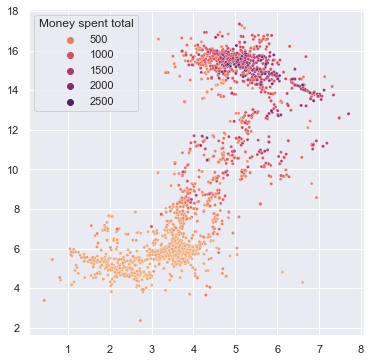

In [76]:
plt.figure(figsize=(6, 6))

sns.scatterplot(
    x=embedding[:, 0], y=embedding[:, 1], s=10, hue=money_spent_total, palette="flare"
)

All the customers are ordered such that customers with low spending are on one end and customers with high spending are on the other end.


### Clusteranalysis

Unsupervised clustering


In [77]:
clusterer = HDBSCAN(
    min_cluster_size=150,
    min_samples=5,
)

clusters = clusterer.fit_predict(embedding)

Plot detected clusters


<AxesSubplot:>

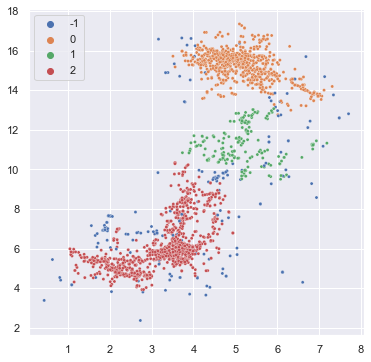

In [78]:
# Cell for rendering online
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    s=10,
    hue=clusters,
    palette="deep",
    # color="gray"
)

In [79]:
import plotly.express as px

fig = px.scatter_3d(
    pd.DataFrame(embedding),
    x=0,
    y=1,
    z=2,
    color=clusters.astype("str"),
    # color=money_spent_total,
)
fig.update_traces(marker_size=2)

In [94]:
print(
    "Number of cusomers in each group: \n"
    f"{money_spent_total.groupby(clusters).count()}"
)
print(
    "Money spent per cluster (total): \n" f"{money_spent_total.groupby(clusters).sum()}"
)
print(
    "Proportion spent per cluster: \n"
    f"{100 * money_spent_total.groupby(clusters).sum() / money_spent_total.sum()}"
)

Number of cusomers in each group: 
-1     189
 0     758
 1     192
 2    1101
Name: Money spent total, dtype: int64
Money spent per cluster (total): 
-1     85854
 0    928529
 1    168397
 2    174208
Name: Money spent total, dtype: int64
Proportion spent per cluster: 
-1     6.326806
 0    68.425734
 1    12.409616
 2    12.837844
Name: Money spent total, dtype: float64


### Three main clusters

    1. Large cluster, high spending
    2. small cluster, medium spending
    3. Large cluster, low spending


### Describe Clusters


[Text(0.5, 0, 'Money spent total')]

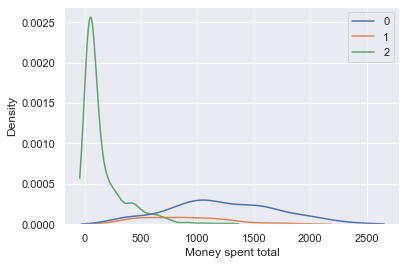

In [81]:
plot = sns.kdeplot(
    data=data_original[clusters != [-1]],
    x=money_spent_total[clusters != -1],
    hue=clusters[clusters != -1],
    # multiple="stack",
    palette="deep",
    cut=1,
    # log_scale=True
)

plot.set(xlabel="Money spent total")

<AxesSubplot:xlabel='Income', ylabel='Density'>

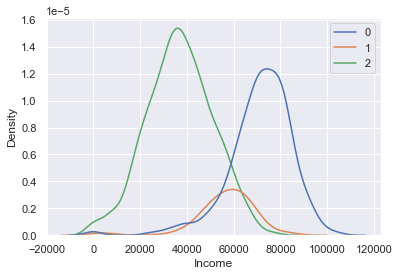

In [82]:
sns.kdeplot(
    x=data_original[clusters != -1].Income + 1,
    hue=clusters[clusters != -1],
    # multiple="fill",
    palette="deep",
)

<AxesSubplot:xlabel='Kidhome', ylabel='Count'>

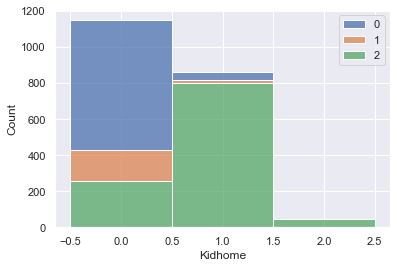

In [83]:
sns.histplot(
    data=data_original[clusters != -1],
    x="Kidhome",
    hue=clusters[clusters != -1],
    multiple="stack",
    palette="deep",
    element="bars",
    discrete=True,
)

<AxesSubplot:xlabel='Education', ylabel='Count'>

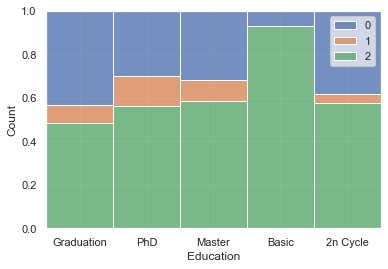

In [84]:
sns.histplot(
    data=data_original[clusters != -1],
    x="Education",
    hue=clusters[clusters != -1],
    multiple="fill",
    palette="deep",
    bins=50,
    element="bars",
    discrete=True,
    # kde=True,
    # log_scale=True
)

<AxesSubplot:xlabel='Response', ylabel='Count'>

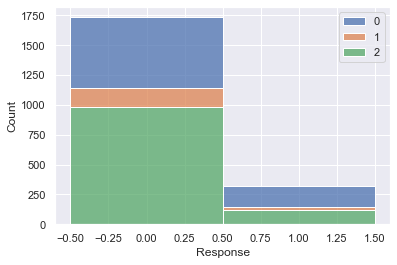

In [85]:
sns.histplot(
    data=data_original[clusters != -1],
    x="Response",
    hue=clusters[clusters != -1],
    multiple="stack",
    palette="deep",
    discrete=True,
)

[Text(0.5, 0, 'Year of birth')]

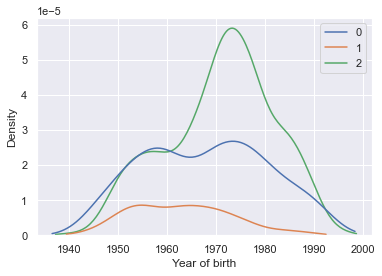

In [86]:
import matplotlib.dates as mdates

plot = sns.kdeplot(
    x=data_original[clusters != -1].Year_Birth.clip("1940"),
    hue=clusters[clusters != -1],
    cut=1,
    palette="deep",
)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

plot.xaxis.set_major_locator(locator)
plot.xaxis.set_major_formatter(formatter)
plot.set(xlabel="Year of birth")

### Describe buying behavior


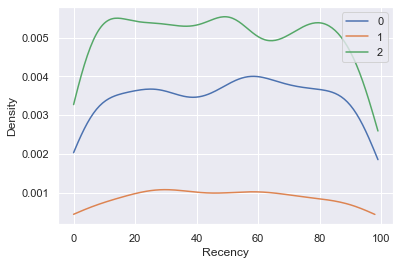

In [87]:
plot = sns.kdeplot(
    x=data_original[clusters != -1].Recency,
    hue=clusters[clusters != -1],
    cut=0,
    palette="deep",
)

<AxesSubplot:xlabel='MntGoldProds', ylabel='Density'>

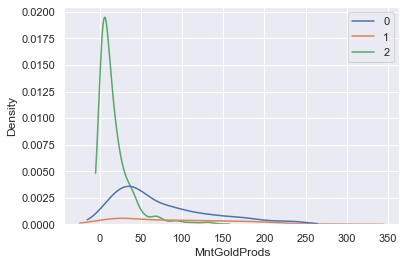

In [88]:
sns.kdeplot(
    data=data_original[clusters != -1],
    x="MntGoldProds",
    hue=clusters[clusters != -1],
    cut=1,
    palette="deep",
)

<AxesSubplot:xlabel='MntWines', ylabel='Density'>

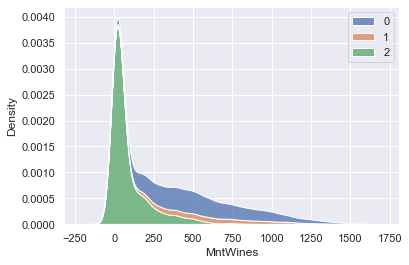

In [89]:
sns.kdeplot(
    data=pd.DataFrame(data_original)[clusters != -1],
    x="MntWines",
    hue=clusters[clusters != -1],
    multiple="stack",
    # discrete=True,
    palette="deep",
)

C:\tools\miniconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.



<AxesSubplot:xlabel='NumDealsPurchases', ylabel='Density'>

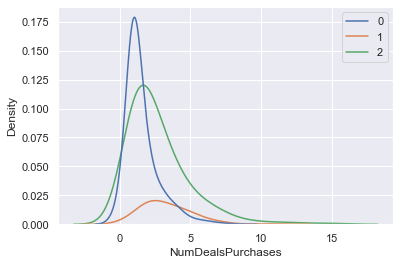

In [90]:
sns.kdeplot(
    data=pd.DataFrame(data_original)[clusters != -1],
    x="NumDealsPurchases",
    hue=clusters[clusters != -1],
    palette="deep",
    # multiple="stack",
    bw=0.5,
)

C:\tools\miniconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1 for `bw_method`, but please see the docs for the new parameters and update your code.



<AxesSubplot:xlabel='NumAcceptedTotal', ylabel='Density'>

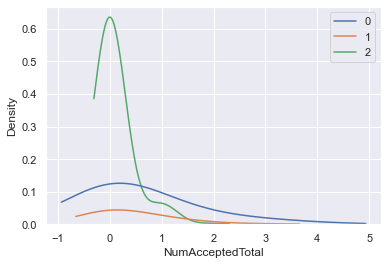

In [91]:
sns.kdeplot(
    data=pd.DataFrame(data, columns=data_columns)[clusters != -1],
    x="NumAcceptedTotal",
    hue=clusters[clusters != -1],
    cut=1,
    palette="deep",
    # multiple="stack",
    bw=1,
)

[Text(0.5, 1.0, 'Average amount spent and number of purchases per cluster ')]

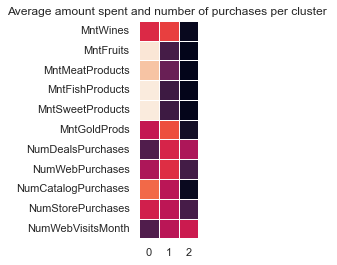

In [96]:
cluster_groups = data_original.loc[:, "MntWines":"NumWebVisitsMonth"][
    clusters != -1
].groupby(clusters[clusters != -1])

g = sns.heatmap(
    (cluster_groups.mean() / cluster_groups.mean().sum()).T,
    square=True,
    linewidths=1,
    cbar=False,
)

g.set(title="Average amount spent and number of purchases per cluster ")

## Conclusions

- we have three distinct customer groups
- We analyzed the clusters first personal features and then the buying behavior

### Result

Group A:

- High Income
- High spending
- No kids
- Buys from all categories
- Doesn't use Deals
- Low number of web visits, but many web purchases

Group B:

- Medium Income and medium spending
- Buys gold and wine
- Uses deals
- Many web visits and web purchases
- oldest (1966 born average)
- 0 or 1 kid

Group C:

- Low income and spending
- Uses website regularly to get deals
- One kid on average

Group A and B are stable under clustering, Group C can be divided in smaller sub groups
